# Fermi-Pasta-Ulam (FPU) problem

Consider a chain of N  particles with nearest neighbour interaction given
by a potential V:


$$ H = \sum_{j=0}^{N} \left[\frac{1}{2} y_{j}^2 + V(x_{j+1} - x_{j}) \right]$$

with fixed boundary conditions $x_{0} = x_{N +1 } = 0$.

FPU $\alpha, \beta-$ model is defined by following potential:

$$ V(x_{j+1} - x_{j}) = \frac{(x_{j+1} - x_{j})^2}{2} + \alpha \frac{(x_{j+1} - x_{j})^3}{3} + \beta \frac{(x_{j+1} - x_{j})^4}{4}$$

Hamilton equations:

$$\begin{aligned}
\frac{dy_{j}}{dt} &= -\frac{\partial H}{dx_{j}}= (x_{j+1} + x_{j-1} -2 x_{j}) + \alpha (x_{j+1} - x_{j})^2 - \alpha (x_{j} - x_{j-1})^2 + \beta (x_{j+1} - x_{j})^3 - \beta (x_{j} - x_{j-1})^3\\
\\
\frac{dx_{j}}{dt} &= \frac{\partial H}{dy_{j}}= y_{j}
\end{aligned}$$

Final equation 

$$ \ddot{x}_{j} = (x_{j+1} + x_{j-1} -2 x_{j}) \left[1 + \alpha(x_{j+1} - x_{j-1}) + \beta(x_{j+1}^2 + x_{j-1}^2 + x_{j}^2 - x_{j} x_{j+1} - x_{j} x_{j-1} - x_{j+1} x_{j-1})\right]$$

$\alpha$-FPU model ($\beta = 0$):

$$ \ddot{x}_{j} = (x_{j+1} + x_{j-1} -2 x_{j}) \left[1 + \alpha(x_{j+1} - x_{j-1}) \right]$$

Second order symplectic scheme: 

$$  \dot{x}_{j}^{n} = y_{j}^{n} $$

$$ \dot{y}_{j}^{n} = (x_{j+1}^{n} + x_{j-1}^{n} -2 x_{j}^{n}) \left[1 + \alpha(x_{j+1}^{n} - x_{j-1}^{n}) \right] =  G(x^{n})$$

$$x^{n+1/2}_{j} = x^{n}_{j} + \frac12 y^{n}_{j} dt$$
$$y^{n+1}_{j} = y^{n}_{j}+G\left(x^{n+1/2}\right) dt$$
$$x^{n+1}_{j} = x^{n+1/2}_{j}+\frac12 y^{n}_{j} dt$$

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def alpha_model(x, alpha):
    G = np.zeros_like(x)
    
    #  G = a * (1 + alpha * b)
    a = x[0:-2] + x[2:] - 2 * x[1:-1]
    b = x[2:] - x[0:-2]
    G[1:-1] = a + alpha * a * b
    
    return G
    
def symplectic_step(x, y, dt, alpha):
    x +=  0.5 * y * dt
    y += alpha_model(x, alpha) * dt
    x +=  0.5 * y * dt 
    
def leapfrog_step(x, y, dt, alpha):
    y += alpha_model(x, alpha) * dt / 2
    x += y * dt
    y += alpha_model(x, alpha) * dt / 2
    

Energy of each normal mode:

$$ E_{j} = \frac{ \pi_{j}^2 + \omega_{j}^2 A_{j}^2}{2}, \quad j = 0,..N-1, \quad \omega_{j} = 2 \sin(\frac{\pi j}{N}) $$

where ($\pi$, $A$) are normal variables obtained from Fourier transform of ($x$, $y$).



In [3]:
def normal_modes_energy_fft(x, y):
    N = len(x) 

    A = np.sqrt(2 / (N - 1)) * np.imag(np.fft.fft(np.concatenate((-np.flip(x[1:-1]), x[:-1]))))
    pi = np.sqrt(2 / (N - 1)) * np.imag(np.fft.fft(np.concatenate((-np.flip(y[1:-1]), y[:-1]))))
    omega = 2 * np.sin(np.pi / (2*N - 2) * np.arange(N))
        
    pi = pi[:N]
    A = A[:N]
    energy = 0.5 * (pi * pi + omega * omega * A * A)

    return energy


def normal_modes_energy(x, y):
    N = len(x)
    
    sin = np.sin(np.pi / (N - 1) * np.arange(N).reshape(-1,1) * np.arange(N))
    A = np.sqrt(2 / (N - 1)) * np.tensordot(x, sin, axes=((0,), (1,)))
    pi = np.sqrt(2 / (N -  1)) * np.tensordot(y, sin, axes=((0,), (1,)))
    
    omega = 2 * np.sin(np.pi * np.arange(N) / (2*N - 2))
    
    energy = 0.5 * pi * pi + 0.5 * omega * omega * A * A
    
    return energy 

In [4]:
def evolution(T, x0, y0, N=32, dt=0.02, alpha=0.25):
    x = x0[:]
    y = y0[:]
            
    steps = int(T / dt)
    
    profiles = np.zeros((int(steps / 10), N))
    energies = np.zeros((int(steps / 10), N))
    energies_fft = np.zeros((int(steps / 10), N))
    
    for n in range(steps):
        if n % 10 == 0:
            profiles[n // 10, :] = x
            energies[n // 10, :] = normal_modes_energy(x, y)
            energies_fft[n // 10, :] = normal_modes_energy_fft(x, y)
        
        symplectic_step(x, y, dt, alpha)
        #leapfrog_step(x, y, dt, alpha)
        
    return profiles, energies, energies_fft

In [5]:
N = 32
x0 = np.zeros(N)
y0 = -np.sin(np.arange(N) * np.pi / (N-1)) # first normal mode of linear system

profiles, energies, energies_fft  = evolution(9000, x0, y0, N, alpha=0.025)

In [2]:
from matplotlib.pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.animation as animation
from IPython.display import HTML


def animate_simulation(profiles, energies, file_name):
	# Sent for figure
	font = {'size'   : 9}
	matplotlib.rc('font', **font)

	# Setup figure and subplots
	f0 = figure(num = 0, figsize = (12, 8))#, dpi = 100)
	f0.suptitle("", fontsize=12)
	ax01 = subplot2grid((2, 2), (0, 0))
	ax02 = subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)
	#tight_layout()

	# Set titles of subplots
	ax01.set_title('oscillators')
	ax02.set_title('Behaviour of the first four normal modes')

	# set y-limits
	ax01.set_ylim(-10,10) 
	ax02.set_ylim(0,10)

	# sex x-limits
	ax01.set_xlim(0,10)
	ax02.set_xlim(0, 100.0)

	# Turn on grids
	ax01.grid(True)
	ax02.grid(True)

	# set label names
	ax01.set_xlabel("")
	ax01.set_ylabel("")

	ax02.set_xlabel("t")
	ax02.set_ylabel("E")

	# Data Placeholders
	yp1=zeros(0)

	t=zeros(0)

	# set plots
	p011, = ax01.plot(t, yp1,'b-', label="yp1")

	p021, = ax02.plot(t, yp1, label="1 mode")
	p022, = ax02.plot(t, yp1, label="2 mode")
	p023, = ax02.plot(t, yp1, label="3 mode")
	p024, = ax02.plot(t, yp1, label="4 mode")


	# set lagends
	ax02.legend([p021,p022, p023, p024], [p021.get_label(), p022.get_label(), p023.get_label(), p024.get_label()])

	t = 0
	steps = energies.shape[0]
	energy_time = np.linspace(0, 100, steps)

	springs_pos = np.linspace(0, 10, len(profiles[0]))

	def animate(self):
		global t
	
		if t < steps:
			p011.set_data(springs_pos, profiles[t,:])
			p021.set_data(energy_time[:t], energies[:, 1][:t])
			p022.set_data(energy_time[:t], energies[:, 2][:t])
			p023.set_data(energy_time[:t], energies[:, 3][:t])
			p024.set_data(energy_time[:t], energies[:, 4][:t])

			t += 1

		return p011, p021

	# interval: draw new frame every 'interval' ms
	# frames: number of frames to draw
	simulation = animation.FuncAnimation(f0, animate, blit=False, frames=4000, interval=20, repeat=False)

	# Uncomment the next line if you want to save the animation
	simulation.save(filename=file_name, fps=30, dpi=300)


In [3]:
HTML('<center><video controls autoplay loop src="mode_energies.mp4" width=100%/></center>')

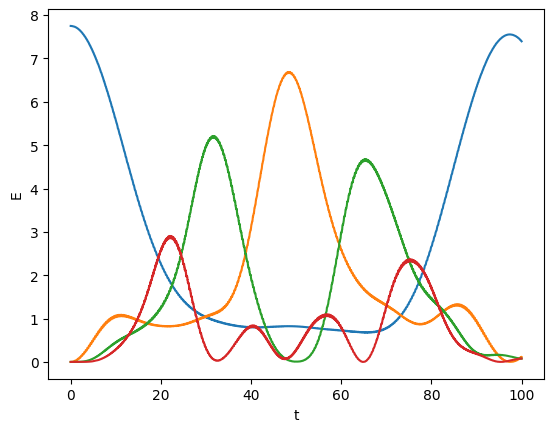

In [8]:
steps = energies.shape[0]
energy_time = np.linspace(0, 100, steps)

plt.xlabel("t")
plt.ylabel("E")

plt.plot(energy_time, energies[:,1])
plt.plot(energy_time, energies[:,2])
plt.plot(energy_time, energies[:,3])
plt.plot(energy_time, energies[:,4])

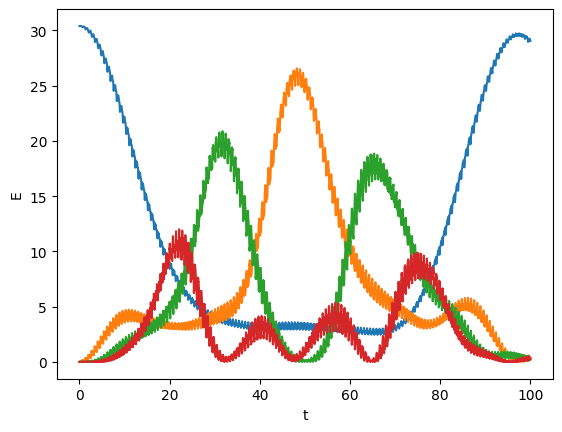

In [9]:
plt.xlabel("t")
plt.ylabel("E")

plt.plot(energy_time, energies_fft[:,1])
plt.plot(energy_time, energies_fft[:,2])
plt.plot(energy_time, energies_fft[:,3])
plt.plot(energy_time, energies_fft[:,4])

## Solution of the FPU paradox

In [10]:
# difference field 
N = 32
delta_x = profiles[:, 1:] - profiles[:, :-1]
delta_x2 = delta_x * delta_x
#plt.plot(np.arange(N-1), delta_x[1000,:])


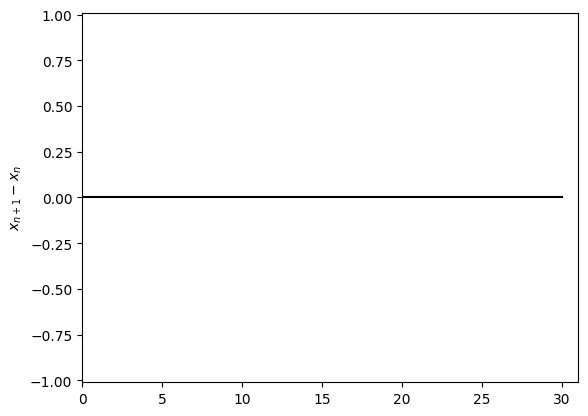

In [12]:
fig, ax = plt.subplots()

def animate(i):     
    ax.clear()
    ax.set_xlim(( 0, N-1))
    ax.set_ylim((-1.01, 1.01))
    ax.set_ylabel("$x_{n+1} - x_{n}$")
    #a = ax.fill_between(pos, x, 0, color = "green", alpha=0.2)
    a = ax.plot(np.arange(N-1), delta_x[i,:], "black")

# call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, frames=200,  interval=20, blit=False)
anim.save(filename='simul_soliton.mp4',fps=30,dpi=300)

HTML(anim.to_html5_video())

The sinusoidal initial condition breaks into a series of pulses, which are solitons. They preserve their shapes and velocities and,
during their motion in the finite system, from time to time, they come back to the positions that they had initially, restoring the initial condition. This is why FPU recurrence is observed.


FPU model can be approximated by Toda lattice model, which is completely integrable:

$$ H = \sum_{j=0}^{N} \left[\frac{1}{2} y_{j}^2 + V(x_{j+1} - x_{j}) \right]$$


$$ V(x_{j+1} - x_{j}) = e^{-(x_{j+1} - x_{j})} + x_{j+1} - x_{j} - 1$$

It has kink-like solitonic solutions:

$$ x_{j}(t) = \pm \frac{1}{2 \alpha} \log \frac{1 + e^{[2 k (j - 1 - j_{0}) \pm t \sinh k]}}{1 + e^{[2 k (j - j_{0}) \pm t \sinh k]}}, $$

where $k$ - inverse width.

So we can construct initial conditions for our FPU lattice from it:


$$ x_{j}(0) = \frac{1}{2 \alpha} \log \frac{1 + e^{[2 k (j - 1 - j_{01})]}}{1 + e^{[2 k (j - j_{01})]}} - \frac{1}{2 \alpha} \log \frac{1 + e^{[2 k (j - 1 - j_{02})]}}{1 + e^{[2 k (j - j_{02})]}} $$


$$ y_{j}(0) = \dot{x}_{j}(t)|_{t=0} = \frac{\sinh k}{2 \alpha} \left( \frac{e^{2 k (j - 1 - j_{01})}}{(1+ e^{2 k (j - 1 - j_{01})}) } -  \frac{e^{2 k (j - j_{01})}}{(1+ e^{2 k (j - j_{01})}) } +  \frac{e^{2 k (j - 1 - j_{02})}}{ (1 + e^{2 k (j -1 - j_{02})})}  -  \frac{e^{2 k (j  - j_{02})}}{ (1 + e^{2 k (j - j_{02})})}\right) $$


In [13]:
N = 128
alpha =  1/3

j01 = 32 
j02 = 128 - 32
k = 1

expj01 = np.exp(2 * k * (np.arange(N) - j01)) 
expj02 = np.exp(2 * k * (np.arange(N) - j02)) 

x0 = 1 / (2 * alpha) * (np.log((1 + np.exp(-2 * k) * expj01) / (1 + expj01)) - np.log((1 + np.exp(-2 * k) * expj02) / (1 + expj02)))

y0 = np.sinh(k) / (2 * alpha) * (np.exp(-2 * k) * expj01 / (1 + np.exp(-2 * k) * expj01) -  expj01 / (1 + expj01) +
                                                         np.exp(-2 * k) * expj02 / ((1 + np.exp(-2 * k) * expj02)) - expj02 / (1 + expj02))


soliton_profiles, soliton_energies, soliton_energies_fft  = evolution(1000, x0, y0, N, alpha=alpha)

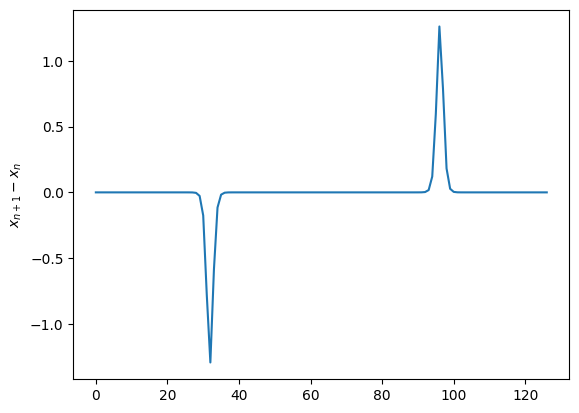

In [14]:
delta_x = soliton_profiles[:, 1:] - soliton_profiles[:, :-1]
delta_x2 = delta_x * delta_x

plt.ylabel("$x_{n+1} - x_{n}$")
plt.plot(np.arange(N-1), delta_x[1,:])

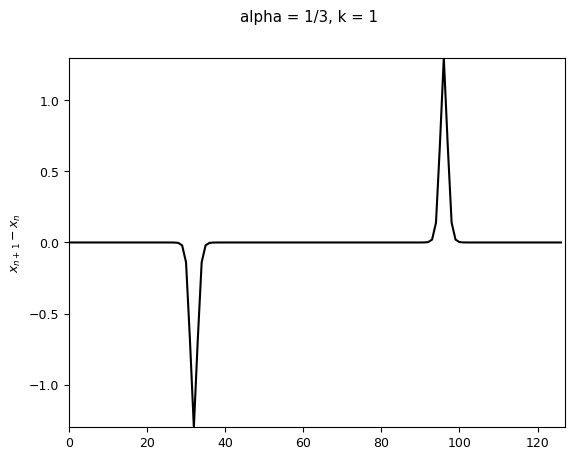

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("alpha = 1/3, k = 1")

def animate(i):     
    ax.clear()
    ax.set_xlim(( 0, N-1))
    ax.set_ylim((-1.3, 1.3))
    ax.set_ylabel("$x_{n+1} - x_{n}$")
    #a = ax.fill_between(pos, x, 0, color = "green", alpha=0.2)
    a = ax.plot(np.arange(N-1), delta_x[i,:], "black")

# call the animator. blit=True means only re-draw the parts that have changed.

anim = animation.FuncAnimation(fig, animate, frames=2000,  interval=20, blit=False)
anim.save(filename='kink_antikink_alpha0.33_k=1.mp4',fps=30,dpi=300)

HTML(anim.to_html5_video())

In [4]:
HTML('<center><video controls autoplay loop src="soliton_collisions_k=0.1.mp4" width=100%/></center>')

In [5]:
HTML('<center><video controls autoplay loop src="soliton_collisions_k=1.mp4" width=100%/></center>')

## Other initial conditions 

For first mode with bigger amplitude thermalization occurs.

In [15]:
N = 32
x0 = np.zeros(N)
y0 = -11 * np.sin(np.arange(N) * np.pi / (N-1)) # first normal mode of linear system

profiles, energies, energies_fft  = evolution(9000, x0, y0, N, alpha=0.025)

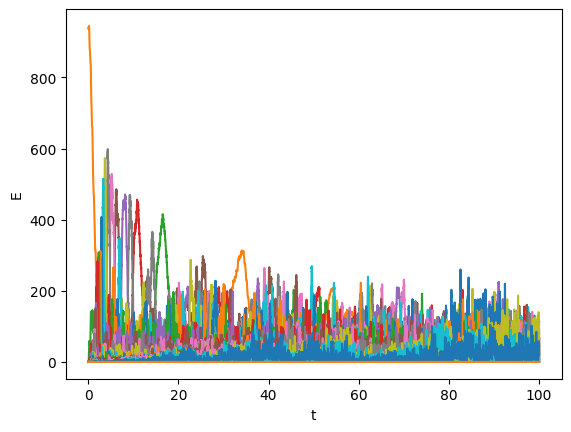

In [16]:
steps = energies.shape[0]
energy_time = np.linspace(0, 100, steps)

plt.xlabel("t")
plt.ylabel("E")

for mode in np.arange(N):
    plt.plot(energy_time, energies[:,mode])


In [17]:
N = 32
x0 = np.zeros(N)
y0 = - np.sin(np.arange(N) *  (N -2) * np.pi / (N-1)) #  normal mode of linear system

profiles, energies, energies_fft  = evolution(9000, x0, y0, N, alpha=0.025)

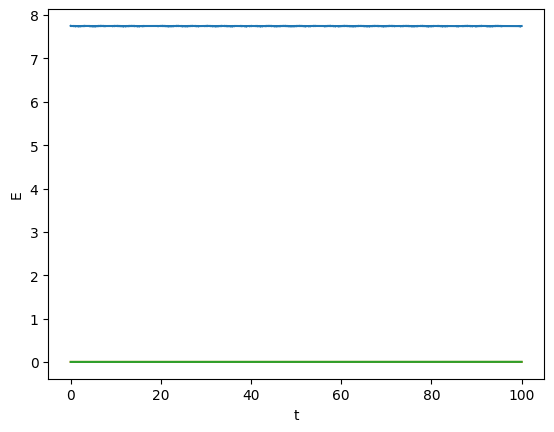

In [18]:
steps = energies.shape[0]
energy_time = np.linspace(0, 100, steps)

plt.xlabel("t")
plt.ylabel("E")

#for mode in np.flip(np.arange(N))[:5]:
#    plt.plot(energy_time, energies[:,mode])

plt.plot(energy_time, energies[:,N-2])
plt.plot(energy_time, energies[:,N-3])
plt.plot(energy_time, energies[:,N-4])